In [15]:
import pandas as pd
import csv
import re

# Song Lyric Classification
[Dataset](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information/data)

In [2]:
song_lyrics = pd.read_csv('song_lyrics.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'song_lyrics.csv'

In [ ]:
song_lyrics.head()

In [4]:
song_lyrics['tag'].value_counts()

tag
pop        2138587
rap        1724816
rock        793220
rb          196462
misc        181455
country     100316
Name: count, dtype: int64

In [5]:
# Removing songs that are not in english
eng_song_lyrics = song_lyrics[song_lyrics['language'] == 'en']
eng_song_lyrics.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


In [6]:
# Creating sample dataset with 10000 random songs
sample = eng_song_lyrics.sample(10000, random_state=0)
sample.to_csv('sample_song_lyrics.csv', sep=',')

## Splitting data into training, testing, and development sets

In [16]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('sample_song_lyrics.csv')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['tag'], test_size=0.2,random_state=0)

In [18]:
# create dev set 
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2,random_state=0)

In [19]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
dev = pd.merge(X_dev, y_dev, left_index=True, right_index=True)
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [20]:
# writing the datasets to csv files
train.to_csv('sample_training.csv', sep=',')
dev.to_csv('sample_dev_full.csv', sep=',')
test.to_csv('sample_test_full.csv', sep=',')
X_dev.to_csv('sample_dev_test.csv', sep=',')
X_test.to_csv('sample_test.csv', sep=',')

## Baseline System: TFIDF with cosine similarity
1. Create vectors for the 6 tags
2. Create vectors of training set input

In [21]:
categories = ['pop','rap','rock','rb','misc','country']

In [22]:
# preparing song lyrics: removing stopwords, punctuation, etc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer 
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# list of descriptors found within lyrics (we can add more if they come up)
stop_words = stop_words.union({'intro', 'x', 'chorus', 'chorusx', 'verse one', 'verse', 'pre', 'post', 'pre-chorus', 'prechorus', 'verse two', 'post-chorus', 'one', 'two', 'postchorus'})

tk = WhitespaceTokenizer()
lem = WordNetLemmatizer()

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [23]:
def clean_lyrics(lyrics):
    clean = lyrics.strip().replace('\n', ' ').replace('[', '').replace(']', '').replace('(', '').replace(')', '')
    clean = tk.tokenize(clean)
    clean = [re.sub(r'[^\w\s]', '', token) for token in clean if re.sub(r'[^\w\s]', '', token)] # remove punctuation
    clean = [re.sub(r'\d+', '', token) for token in clean if re.sub(r'\d+', '', token)] # remove numbers
    clean = [w for w in clean if not w.lower() in stop_words] # remove stopwords
    clean = [lem.lemmatize(w) for w in clean]
    return clean

In [24]:
# clean and tokenize X_train
X_train_cl = pd.Series([clean_lyrics(x) for x in X_train])
X_dev_cl = pd.Series([clean_lyrics(x) for x in X_dev])
X_test_cl = pd.Series([clean_lyrics(x) for x in X_test])

In [25]:
# creating tfidf vectors of training set
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x) #overwriting the tokenization and preprocessing step since done above
X_train_vectors = vectorizer.fit_transform(X_train_cl) # creating tfidf vectors of training set

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Training a model to predict genres 
1. With the tfidf vectors we can use logistic regression as our baseline model and train on the x vector set 
2. Run the regression on the development set and test set after

In [26]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()
reg.fit(X_train_vectors, y_train)

LogisticRegression()

In [27]:
# running model on development set
X_dev_vectors = vectorizer.transform(X_dev_cl)
y_dev_pred = reg.predict(X_dev_vectors)

Logistic Regression doesnt support incremental learning so having a development set doesn't make a lot of sense in this situation, but it will be helpful for other models

In [28]:
# running model on test set
X_test_vectors = vectorizer.transform(X_test_cl)
y_test_pred = reg.predict(X_test_vectors)

## Evaluation

Compute the following metrics: 

- accuracy
- precision
- recall
- f-score

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_model(prediction, result):
    accuracy = accuracy_score(result, prediction)
    precision = precision_score(result, prediction, average='micro')
    recall = recall_score(result, prediction, average='micro')
    f1 = f1_score(result, prediction, average='micro')

    return f'Evaluation Results \n accuracy: {accuracy}\n precision: {precision}\n recall: {recall}\n f score: {f1}'

In [30]:
print(evaluate_model(y_dev_pred, y_dev))

Evaluation Results 
 accuracy: 0.608125
 precision: 0.608125
 recall: 0.608125
 f score: 0.608125


In [31]:
print(evaluate_model(y_test_pred, y_test))

Evaluation Results 
 accuracy: 0.626
 precision: 0.626
 recall: 0.626
 f score: 0.626


In [32]:
# transformer

## Training Model using k-Nearest Neighbors
1. Determine best hyperparameters
2. Train kNN classifier with those hyperparameters

In [63]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

error = list() 

for i in range(1, 30): 
    knn = KNeighborsClassifier(n_neighbors=i, metric='cosine')
    knn.fit(X_train_vectors, y_train)
    pred_i = knn.predict(X_dev_vectors)
    error.append(np.mean(pred_i != y_dev)) 

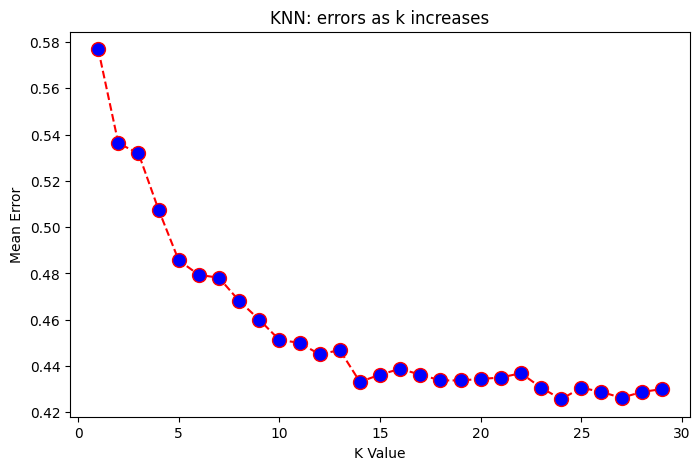

In [64]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(error)+1), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('KNN: errors as k increases')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

In [49]:
knn = KNeighborsClassifier(n_neighbors=14, metric='cosine')
knn.fit(X_train_vectors, y_train)


KNeighborsClassifier(metric='cosine', n_neighbors=14)

### Evaluation

In [69]:
# Evaluate on dev set
y_dev_pred = knn.predict(X_dev_vectors)
print(evaluate_model(y_dev_pred, y_dev))
print()
# Evaluate on test set
y_test_pred = knn.predict(X_test_vectors)
print(evaluate_model(y_test_pred, y_test))

Evaluation Results 
 accuracy: 0.57
 precision: 0.57
 recall: 0.57
 f score: 0.57

Evaluation Results 
 accuracy: 0.592
 precision: 0.592
 recall: 0.592
 f score: 0.592


## Training Model using SVM
1. Determine best hyperparameters
2. Train SVM classifier with those hyperparameters

In [58]:
C_values = np.logspace(-3, 2, 20)
errors = []

for C in C_values:
    svm = LinearSVC(C=C, max_iter=10000)
    svm.fit(X_train_vectors, y_train)
    pred = svm.predict(X_dev_vectors)
    errors.append(np.mean(pred != y_dev))

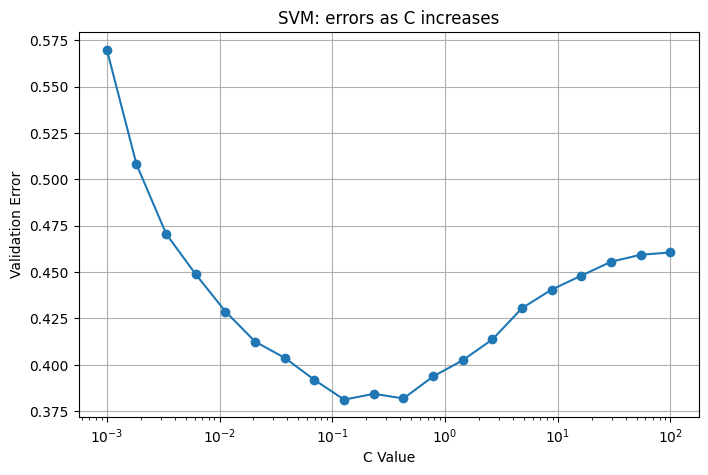

In [67]:
plt.figure(figsize=(8, 5))
plt.semilogx(C_values, errors, marker='o')
plt.xlabel('C Value')
plt.ylabel('Validation Error')
plt.title('SVM: errors as C increases')
plt.grid(True)
plt.show()

In [61]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=C_values[np.argmin(errors)])
svm.fit(X_train_vectors, y_train)

LinearSVC(C=np.float64(0.12742749857031335))

### Evaluation

In [68]:
#Evaluate on dev set
y_dev_pred = svm.predict(X_dev_vectors)
print(evaluate_model(y_dev_pred, y_dev))
print()
# Evaluate on test set
y_test_pred = svm.predict(X_test_vectors)
print(evaluate_model(y_test_pred, y_test))


Evaluation Results 
 accuracy: 0.61875
 precision: 0.61875
 recall: 0.61875
 f score: 0.61875

Evaluation Results 
 accuracy: 0.6305
 precision: 0.6305
 recall: 0.6305
 f score: 0.6305
